<a href="https://colab.research.google.com/github/zar7364/DataScience/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Import the numpy and pandas packages

import numpy as np
import pandas as pd

In [2]:
pip install pyspark

     |████████████████████████████████| 204.2MB 63kB/s 
     |████████████████████████████████| 204kB 42.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=cedfd19f65100ad356ee8a11e4e532b74b94c0c9db451834c3b29f9c1fcc5645
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [3]:
import pyspark

In [4]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [8]:
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()

In [9]:
spark

In [11]:
sc=spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [12]:
sqlContext=SQLContext(spark.sparkContext)
sqlContext

In [13]:
from google.colab import files,drive

In [14]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [27]:
data=('/content/drive/My Drive/Colab Notebooks/Spark/cal_housing.data')

In [28]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

In [29]:
housing_df = spark.read.csv(path=data, schema=schema).cache()

In [31]:
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [33]:
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [36]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [37]:
housing_df.dtypes()

[('long', 'float'),
 ('lat', 'float'),
 ('medage', 'float'),
 ('totrooms', 'float'),
 ('totbdrms', 'float'),
 ('pop', 'float'),
 ('houshlds', 'float'),
 ('medinc', 'float'),
 ('medhv', 'float')]

In [40]:
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



In [41]:
#Data Exploration
housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



In [49]:
#Groupby housing median age and see the distribution

result_df=housing_df.groupBy("medage").count().sort("medage",ascending=False)

In [51]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



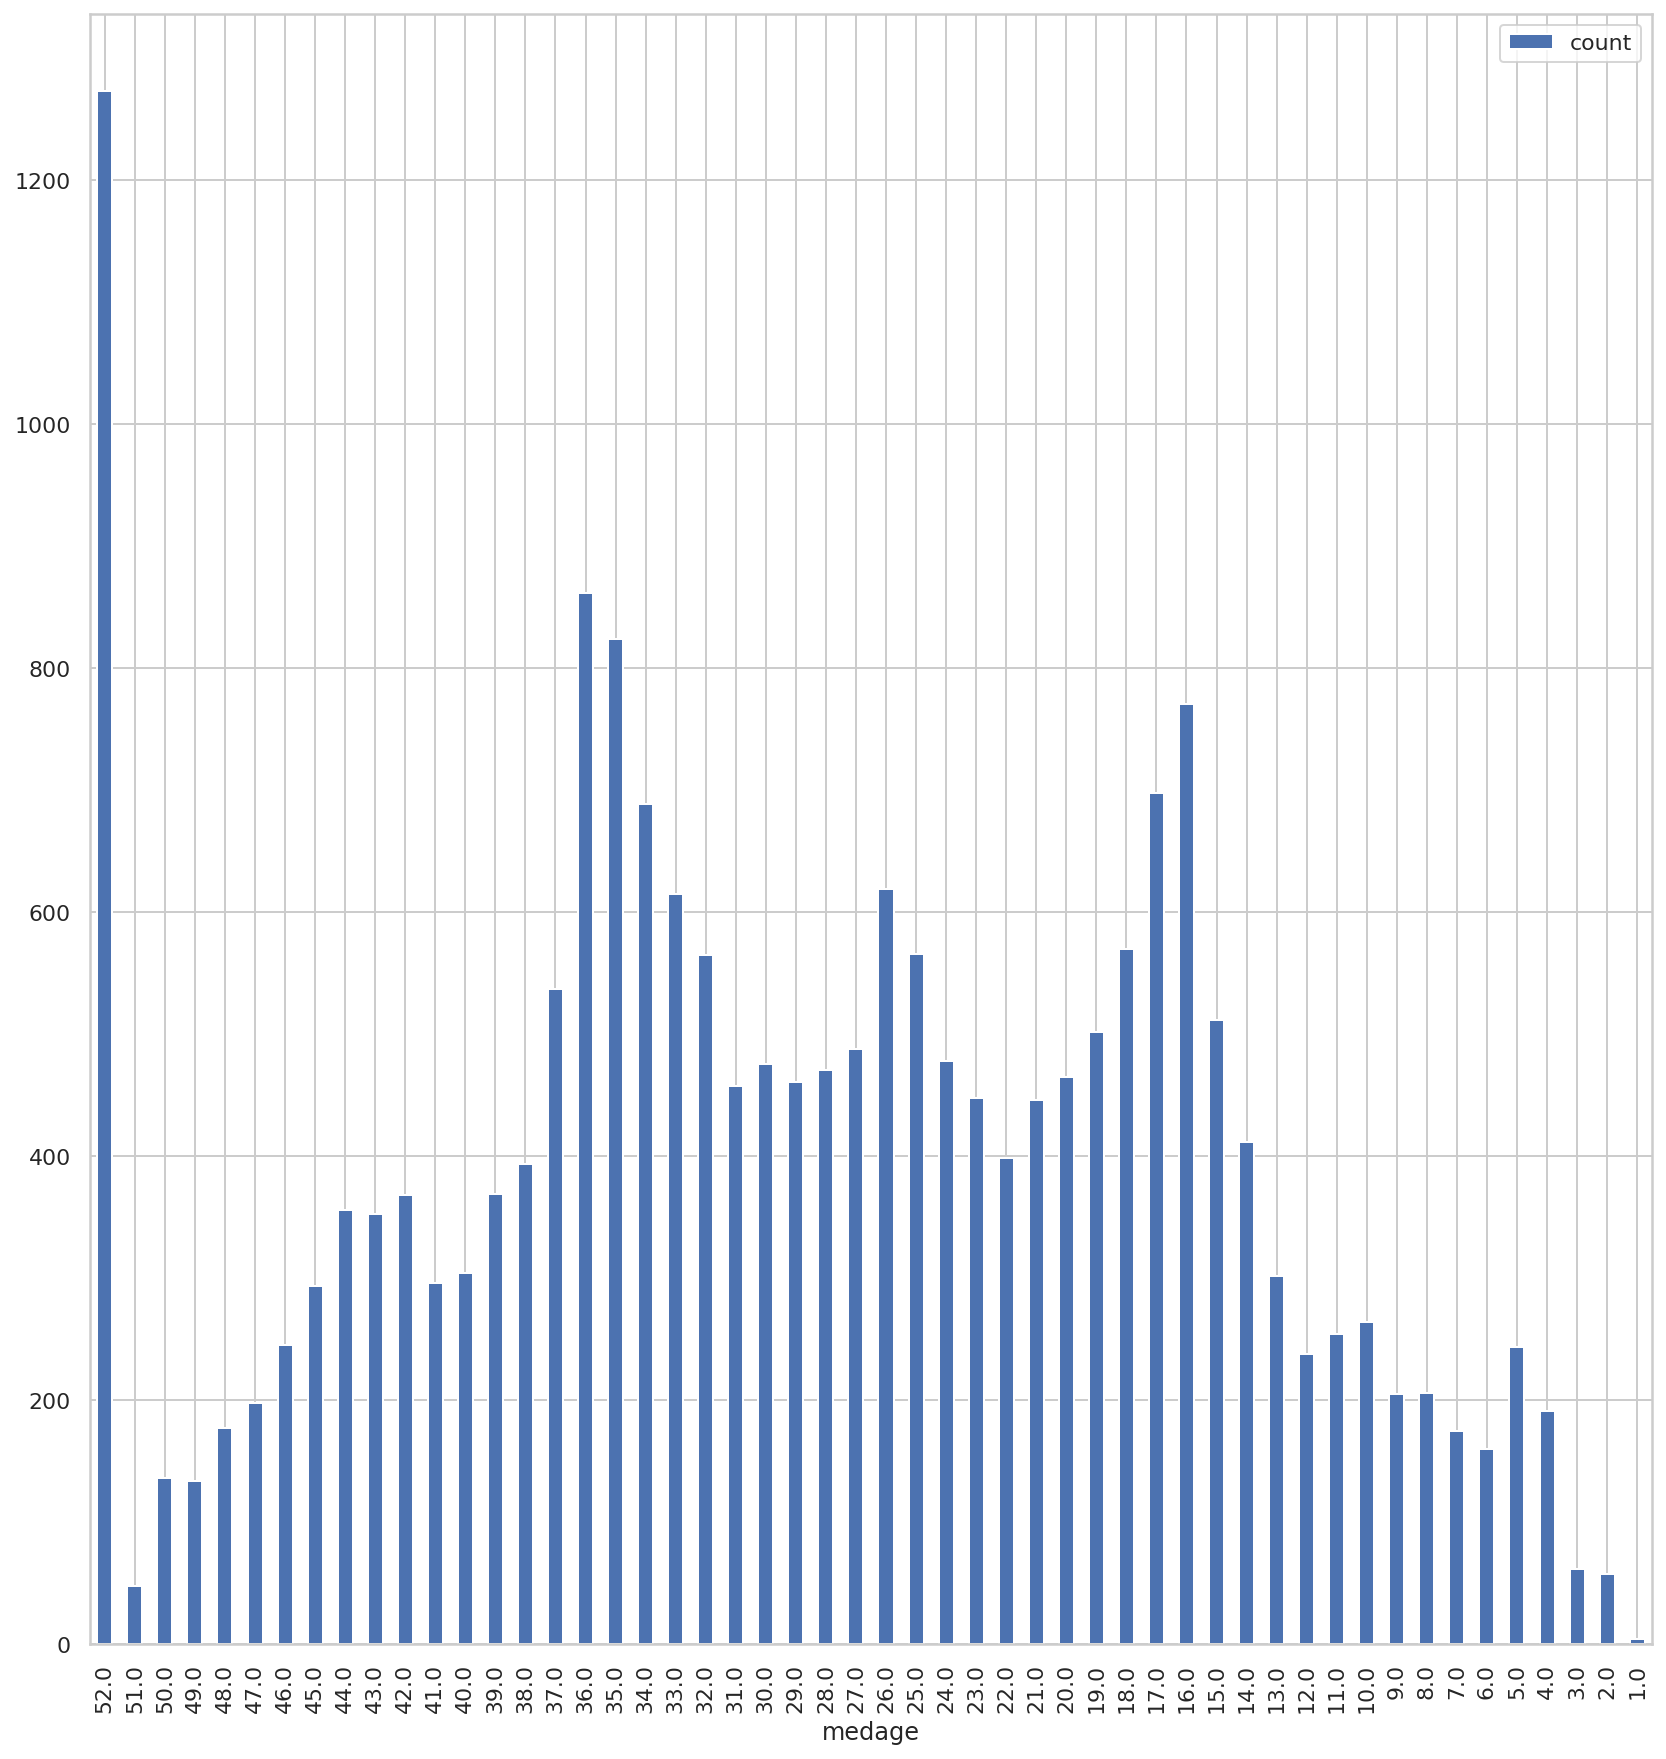

In [52]:
result_df.toPandas().plot.bar("medage",figsize=(14,15))

In [54]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [56]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [57]:
# Show the first 2 lines of `df`
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



In [58]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [59]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [60]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



In [61]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

In [62]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

In [63]:


# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 



In [64]:
assembled_df = assembler.transform(housing_df)

In [65]:


assembled_df.show(10, truncate=False)



+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


In [66]:


# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")



In [67]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [69]:


# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)



+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

In [71]:


# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)



In [73]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

In [74]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [75]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [76]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [77]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [83]:
linearModel.intercept

1.0013833516596085

In [84]:


coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]



In [86]:
coeff_df

,Feature,Co-efficients
0,Intercept,1.001383
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526157
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


In [87]:
#Generating Prediction
predictions=linearModel.transform(test_data)

In [88]:


# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")



In [89]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|  1.14982901467337|0.14999|
|1.3037582901805782|  0.225|
| 1.752972574315186|  0.225|
|1.6094289295308724|  0.269|
|1.5956645319495768|  0.344|
|1.2917940087238426|  0.367|
|1.8668547795751218|  0.375|
| 1.369423339785637|  0.394|
|1.5305533439120043|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043998|  0.417|
| 1.229923204690587|  0.425|
|1.4841640700933143|  0.425|
|1.3510338217435218|   0.43|
|1.2619110212709588|  0.436|
|1.3350814464678744|   0.44|
|1.4832778453641755|   0.44|
|1.4337313361080328|  0.444|
|1.3691187093204966|  0.445|
|  1.47521855868216|  0.446|
+------------------+-------+
only showing top 20 rows



In [91]:
#Inspect The Metric
# Get the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 0.8819852045268861
MAE: 0.6782895319917991
R2: 0.4180854895364573


In [92]:
#Another Version
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))



evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))





evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))



RMSE: 0.8677342923034236
MAE: 0.6736097745764633
R2: 0.42517112885139363


In [93]:
# using pyspark.mlib



# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)



In [95]:


print("RMSE: {0}".format(metrics.rootMeanSquaredError))


print("MAE: {0}".format(metrics.meanAbsoluteError))



print("R2: {0}".format(metrics.r2))



RMSE: 0.8677342923034236
MAE: 0.6736097745764633
R2: 0.42517112885139363


In [96]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x7f1a1da59390>>